In [45]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm

In [79]:
train_size = 800
test_size = 200
samples = test_size + train_size

apple_data = np.load('./doodles/full_numpy_bitmap_apple.npy')[:samples]
tower_data = np.load('./doodles/full_numpy_bitmap_The Eiffel Tower.npy')[:samples]
banana_data = np.load('./doodles/full_numpy_bitmap_banana.npy')[:samples]

apple_data = apple_data/255
tower_data = tower_data/255
banana_data = banana_data/255


In [81]:
training_inputs = np.append(apple_data[:train_size,:], tower_data[:train_size,:], axis = 0)
training_inputs = np.append(training_inputs, banana_data[:train_size,:],axis = 0)
training_outputs = np.array([0]*train_size+[1]*train_size+[2]*train_size)

testing_inputs = np.append(apple_data[train_size:,:], tower_data[train_size:,:], axis = 0)
testing_inputs = np.append(testing_inputs, banana_data[train_size:,:],axis = 0)
testing_outputs = np.array([0]*test_size+[1]*test_size+[2]*test_size)


training_inputs, training_outputs = shuffle(training_inputs, training_outputs)
testing_inputs, testing_outputs = shuffle(testing_inputs, testing_outputs)

training_inputs = np.reshape(training_inputs, (train_size*3,1,28,28))
testing_inputs = np.reshape(testing_inputs, (test_size*3,1,28,28))

0


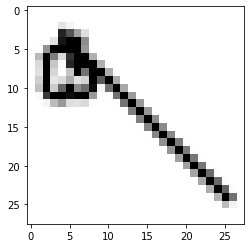

In [82]:
test = training_inputs[1,0]
plt.imshow(test, cmap='Greys')
print(training_outputs[1])

In [83]:
class ConvNetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.f1 = torch.nn.Conv2d(1, 10, kernel_size=(3,3))
        self.f2 = torch.nn.Conv2d(10, 10, kernel_size=(3,3))
        self.l1 = torch.nn.Linear(10 * 5**2, 50)
        self.l2 = torch.nn.Linear(50, 3)
    
    def forward(self,x):
        
        cv1 = F.relu(self.f1(x))
        mp1 = torch.nn.MaxPool2d((2, 2))(cv1)
        cv2 = F.relu(self.f2(mp1))
        mp2 = torch.nn.MaxPool2d((2, 2))(cv2)
        
        flaten = torch.flatten(mp2, start_dim=1)
        
        dl1 = F.relu(self.l1(flaten))
        dl2 = F.softmax(self.l2(dl1), dim = 1)
        
        return(dl2)

In [84]:
model = nn.Sequential(
          nn.Conv2d(1, 10, kernel_size=(3,3)),
          nn.MaxPool2d((2, 2)),
          nn.ReLU(),
          nn.Conv2d(10, 10, kernel_size=(3,3)),
          nn.MaxPool2d((2, 2)),
          nn.Flatten(),
          nn.ReLU(),
          nn.Linear(10 * 5**2, 50),
          nn.ReLU(),
          nn.Linear(50, 3),
          nn.Softmax()
        )

In [85]:

x_training = torch.from_numpy(training_inputs).float()
y_training = torch.from_numpy(training_outputs)

x_testing = torch.from_numpy(testing_inputs).float()
y_testing = torch.from_numpy(testing_outputs)

iterations = 40

#model = ConvNetModel()

loss_fn = torch.nn.CrossEntropyLoss()
loss_hist = []
loss_hist_test = []
optimizer = torch.optim.Adam(model.parameters())


for t in tqdm(range(iterations)):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_training)
    
    # Compute and print loss
    loss = loss_fn(y_pred, y_training)
    
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    test_pred = model(x_testing)
    loss_hist.append(loss.item())
    
    test_loss = loss_fn(test_pred, y_testing)
    loss_hist_test.append(test_loss.item())
    
    
    loss.backward()
    optimizer.step()
    
    

100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


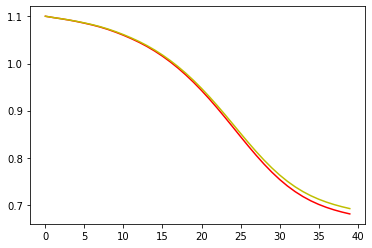

In [86]:

plt.plot(loss_hist,c = "r")
plt.plot(loss_hist_test,c = "y")
plt.show()

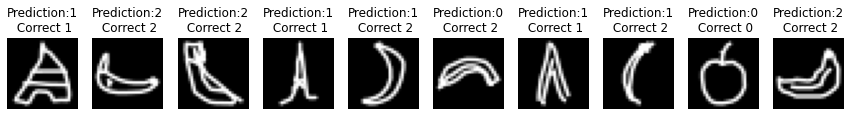

In [90]:
samples = 10
fig, axs = plt.subplots(1,samples)
fig.set_size_inches(15,15)
for ax,i in zip(axs,range(samples)):
    ax.imshow(testing_inputs[i,0],cmap="gray")
    ax.set_title(f'Prediction:{np.argmax(test_pred.detach().numpy()[i])}\n Correct {testing_outputs[i]}')
    ax.axis('off')